In [ ]:
#!pip install dippykit

In [1]:
import numpy as np
import cv2
import zmq
import time
from statistics import stdev
from utils import *
from dippykit.coding import huffman_encode
from dippykit.coding import huffman_decode
import pickle

/Users/nicholassperry/Desktop/Year 4.nosync/Pipeline/utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  I1 = np.uint8(np.true_divide(I1,GI))
/Users/nicholassperry/Desktop/Year 4.nosync/Pipeline/utils.py:200: RuntimeWarning: invalid value encountered in true_divide
  I1 = np.uint8(np.true_divide(I1,GI))


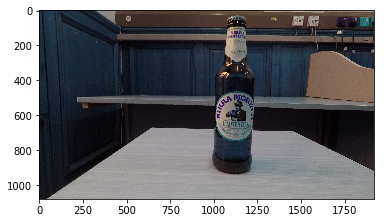

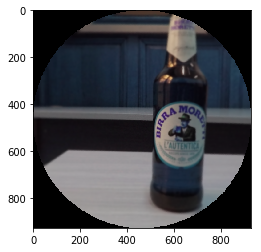

In [19]:
from matplotlib import pyplot as plt
img = cv2.imread('beer.png')
R.sample(img, fixation)

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(R.backproject_tight_last())

In [3]:
def send_image(n=5):
    video_path = '/Users/nicholassperry/Desktop/Dataset.nosync/Dataset/Train/Gargoyle.MOV'
    vidcap = cv2.VideoCapture(video_path)
    success, img = vidcap.read()

    count = 1
    pickling_times = []
    sending_times = []
    total_start = time.time()
    while success:
        if count%n == 0:
            break
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        t1 = time.time()
        data = pickle.dumps(img, protocol=-1)
        #data = img.tostring()
        t2 = time.time()
        
        tracker = socket.send(data, copy=False, track=True)
        while tracker.done == False:
            pass
            
        t3 = time.time()
        
        pickling_times.append(t2-t1)
        sending_times.append(t3-t2)
        
        success, img = vidcap.read()
        count += 1
    total_end = time.time()
    socket.send(b'Done')
    print('Successfully converted video to %d frames'%count)
    
    print('\nProcessing time: %f'%sum(pickling_times))    
    print('Time taken to send: %f'%sum(sending_times))
    print('Overall total time: %f'%(total_end-total_start))

In [22]:
def send_full_vector(n=5):
    video_path = '/Users/nicholassperry/Desktop/Dataset.nosync/Dataset/Train/Gargoyle.MOV'
    vidcap = cv2.VideoCapture(video_path)
    success, img = vidcap.read()

    count = 1
    processing_times = []
    sending_times = []
    total_start = time.time()
    
    while success:
        print(count)
        if count%n == 0:
            break
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        t1 = time.time()
        
        V = R.sample(img, fixation).astype('uint8')
        V = pickle.dumps(V, protocol=-1)
        #V = V.tostring()
        
        t2 = time.time()
        
        tracker = socket.send(V, copy=False, track=True)
        while tracker.done == False:
            pass
            
        t3 = time.time()

        processing_times.append(t2-t1)
        sending_times.append(t3-t2)
        
        success, img = vidcap.read()
        count += 1
    total_end = time.time()
    print('Successfully converted video to %d frames'%count)
    
    print('\nProcessing time: %f'%sum(processing_times))    
    print('Time taken to send: %f'%sum(sending_times))
    print('Overall total time: %f'%(total_end-total_start))

def send_encoded_vector(n):
    video_path = '/Users/nicholassperry/Desktop/Dataset.nosync/Dataset/Train/Gargoyle.MOV'
    vidcap = cv2.VideoCapture(video_path)
    success, img = vidcap.read()

    count = 1
    huffman_times = []
    pickling_times = []
    sending_times = []
    total_start = time.time()
    while success:
        print(count)
        if count%n == 0:
            break
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        V = R.sample(img, fixation).astype('uint8')
        
        t1 = time.time()
        
        encoded_V, bits, code_dict, _ = huffman_encode(V.flatten())
        
        t2 = time.time()
        
        data = [encoded_V, code_dict, bits]
        data = pickle.dumps(data, protocol=-1)
        
        t3 = time.time()
        
        tracker = socket.send(data, copy=False, track=True)
        while tracker.done == False:
            pass

        t4 = time.time()
        
        huffman_times.append(t2-t1)
        pickling_times.append(t3-t2)
        sending_times.append(t4-t3)
        success, img = vidcap.read()
        count += 1
    total_end = time.time()
    
    print('Successfully converted video to %d frames'%count)
    
    print('\nHuffman encoding time: %f'%sum(huffman_times))
    print('Pickling time: %f'%sum(pickling_times))
    print('Time taken to send: %f'%sum(sending_times))
    print('Overall total time: %f'%(total_end-total_start))

In [18]:
R = Retina(gpu=False)
R.loadLoc('/Users/nicholassperry/Desktop/Year 4.nosync/Pipeline/retina_data/ret50k_loc.pkl')
R.loadCoeff('/Users/nicholassperry/Desktop/Year 4.nosync/Pipeline/retina_data/ret50k_coeff.pkl')
fixation = (1080/2,1920/2)
shape = (1080, 1920)
R.prepare(shape, fixation)

In [6]:
context = zmq.Context()

#  Socket to talk to server
print("Connecting to Server…")
socket = context.socket(zmq.PUSH)
socket.connect("tcp://localhost:5555")
time.sleep(3)
send_image(n=100)

socket.close()

Connecting to Server…
Successfully converted video to 100 frames

Processing time: 0.341144
Time taken to send: 1.204865
Overall total time: 2.413456


In [24]:
context = zmq.Context()

#  Socket to talk to server
print("Connecting to Server…")
socket = context.socket(zmq.PUSH)
socket.connect("tcp://localhost:5555")

socket.send(b'Cort')
send_full_vector(n=10)
socket.send(b'Done')

socket.close()

Connecting to Server…
1
2
3
4
5
6
7
8
9
10
Successfully converted video to 10 frames

Processing time: 30.561473
Time taken to send: 0.059962
Overall total time: 30.697197


In [ ]:
context = zmq.Context()
#  Socket to talk to server
print("Connecting to Server…")
socket = context.socket(zmq.PUSH)
socket.connect("tcp://localhost:5555")

send_encoded_vector(img_type=b'Ret', n=5)

socket.close()

In [ ]:
context = zmq.Context()

print("Connecting to Server")
client_socket = context.socket(zmq.PUSH)
client_socket.connect("tcp://localhost:5555")

for i in range(10):
    client_socket.send(b'Hello')